<center>
<div style="max-width:400px;">

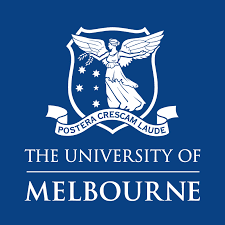

</div>
</center>

# Design of Experiments

**Prof. Kevin Otto and Nikolas Crossan**  
The University of Melbourne  
Department of Mechanical Engineering

----------------------------------------------------------------------------

This notebook demonstrates creating and analyzing factorial designs
1. Full Factorial Designs
2. Fractional Factorial Designs
3. Center Points
4. Central Composite Designs

This notebook relies on the `mqrpy` code library, found at https://pypi.org/project/mqrpy/


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack, grab_figure
from mqr.doe import Design

from importlib.metadata import version
print('MQR version', version('mqrpy'))
print('Numpy version ', version('numpy'))
print('Scipy version ', version('scipy'))
print('Pandas version ', version('pandas'))
print('Seaborn version ', version('seaborn'))
print('StatsModels version ', version('statsmodels'))

# 1. Creating Experimental Design Arrays

## 1.1 Full Factorial Experiments

Next is code to create a full factorial matrix as a Pandas Dataframe. 

The fullfactorial generates a full factorial using levels on X1, X2, ... as [d, d, ...] where d is the number of levels for each variable respectively. 

Next is an example to generate a $2^3$ full factorial design in Yates standard form.  

In [ ]:
var_list = ["x1", "x2", "x3"]
levels = [2, 2, 2]

Design.from_fullfact(var_list, levels)

## 1.2 Two Level Fractional Factorial Design

Next is code to create a fractional factorial matrix as a Pandas Dataframe.  


Next is an example to generate a $2^{n-k}$ fractional factorial design.  

Each column's formula is given as a standard letter format such as `'a b c abc'` for four columns, where then there would be (a, b, c) = 3 independent factors and so $2^3=8$ experimental configurations.  


In [ ]:
var_list = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
gen = 'a b c d abcd abc abd'

Design.from_fracfact(var_list, gen)

## 1.3 Center Points

Augmenting any factorial design is easy enough by adding rows of zero values to a factorial DataFrame. 

Now create a Pandas DataFrame which includes a column indicating whether a factorial point or a center point.

In [ ]:
var_list = ["x1", "x2", "x3", "x4"]
gen = 'a b c abc'
nc = 3    # number of centerpoints

fccd = Design.from_fracfact(var_list, gen)
cccd = Design.from_centrepoints(var_list, nc)
cfd = fccd + cccd
cfd

## 1.4 Central Composite Designs - Full Factorial 

As  default, most DOE packages only provides a central composite design using a full factorial base.  Here, this code generates a CCD array as a combination of whatever blocks you wish.  

The `PointType`is 1 for corner points, 0 for center points, and 2 for axial points. 

Also add a block variable for the first fractional factorial and the subsequent axial point experiments.  

In [ ]:
var_list = ["x1", "x2", "x3", "x4"]
nc = 3        # number of center points to use

In [ ]:
fccd = Design.from_fullfact(var_list, [2, 2, 2, 2])
cccd = Design.from_centrepoints(var_list, nc)
accd = Design.from_axial(var_list)

ccfd = (fccd + cccd).as_block(1) + (accd + cccd).as_block(2)
ccfd

## 1.5 Central Composite Designs - Fractional Factorial 

As  default, pyDOE provides a central composite design using a full factorial base.  There are parameters alpha and face to define what axial points to generate.  The code below generates this full facotrial CCD, and then replaces the full factorial points with fractional factorial points in the CCD.  

This code generates a Pandas DataFrame with additional columns of Point Type and Block indicating corner, axial or center points and how the runs were blocked.  


In [ ]:
var_list = ["x1", "x2", "x3", "x4"]
gen = 'a b c abc'
nc = 3        # number of center points to use

ccfrfd = Design.from_fracfact(var_list, gen)
ccfrcd = Design.from_centrepoints(var_list, nc)
ccfrad = Design.from_axial(var_list)

ccfrd = (ccfrfd + ccfrcd).as_block(1) + (ccfrad + ccfrcd).as_block(2)
ccfrd

------------------------------------------------------------------------------------------

# 2. Analyzing Experimental Designs

## 2.1. Factorial Design Analysis

The basic analysis is a balanced factorial array with no center points. 

### 2.1.1 Example 1

Below is an example of a $2^3$ factorial design, using the catapult as an example. The same approach would be used for a fractional factorial design.  Corner points only.   

Now suppose the experiments were executed at each run. Add the toss results of each run to the dataframe.  

In [ ]:
var_list = ['Ht', 'Theta0', 'Ra']
levels = [2, 2, 2]

ffd = Design.from_fullfact(var_list, levels)
df_ffd = ffd.to_df()
df_ffd['Toss'] = [0.323, 0.725, 1.098, 1.632, 0.724, 1.173, 1.663, 2.305]

df_ffd

Now analyze the data using regression and the StatsModels formula API.  Sequentially drop the insignificant term with highest p-value.  

In [ ]:
form = 'Toss ~ Ht + Theta0 + Ra + Ht*Theta0 + Ht*Ra + Theta0*Ra'
mod = smf.ols(form, df_ffd)
res = mod.fit()

mqr.anova.coeffs(res)

In [ ]:
form = 'Toss ~ Ht + Theta0 + Ra + Ht*Theta0 + Theta0*Ra'
mod = smf.ols(form, df_ffd)
res = mod.fit()

mqr.anova.coeffs(res)

In [ ]:
form = 'Toss ~ Ht + Theta0 + Ra + Theta0*Ra'
mod = smf.ols(form, df_ffd)
res = mod.fit()

mqr.anova.coeffs(res)

In [ ]:
form = 'Toss ~ Ht + Theta0 + Ra'
mod = smf.ols(form, df_ffd)
res = mod.fit()

mqr.anova.coeffs(res)

Now we have a model with all significant terms, all p-values and less than 0.05.  Now construct the residuals and create a 4 in 1 plot of the residuals.  

In [ ]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(res.resid, res.fittedvalues, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(res),
        mqr.inference.dist.test_1sample(res.resid)
    )
)

The residuals do not look normal, there is a a quadratic look versus value.  Likely this could get solved with a transformation of variables.  It is left as an exercise to the student to try fitting the response $Toss^{0.62}$, where thereby the fit improves and the residuals transform to looking random.  

-------------------------------------------------------------------------------------------

### 2.1.2 Example 2 - Full Factorial Design

Now consider a full factorial design with 4 variables, and a response shown. 

In [ ]:
var_list = ["x1", "x2", "x3", "x4"]
levels = [2, 2, 2, 2]
ffd = Design.from_fullfact(var_list, levels)
df_ffd = ffd.to_df()
df_ffd['Response'] = [6.899, 9.769, 7.931, 8.038, 11.366, 13.824, 
                 11.540, 11.659, 7.580, 9.845, 7.008, 7.753,
                 10.296, 12.306, 10.783, 9.923]
df_ffd

Now fit a parsimonious fit with interactions.  What is the best model?

In [ ]:
#form = 'Response ~ x1 + x2 + x3 + x4 + x1*x2 + x1*x3 + x1*x4 + x2*x3 + x2*x4 + x3*x4'
form = 'Response ~ x1 + x2 + x3 + x4 + x1*x2 + x3*x4'
mod = smf.ols(form, df_ffd)
res = mod.fit()

with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(res.resid, res.fittedvalues, axs=ax)
    plot = grab_figure(fig)

hstack(
    vstack(
        mqr.anova.adequacy(res),
        mqr.anova.coeffs(res)
        ),
    plot
)

We see the best model is the linear terms plus the x1*x2 interaction.  The residuals look fine.

### 2.1.2 Example 2 - Half Fraction Design

Now consider the exact same response data, but with a 1/2 fraction design.

In [ ]:
ar_list = ["x1", "x2", "x3", "x4"]
gen = 'a b c abc'
ffd = Design.from_fracfact(var_list, gen)
df_ffd = ffd.to_df()
df_ffd['Response'] = [6.899, 9.845, 7.008, 8.038, 
                      10.296, 13.824, 11.540, 9.923]
df_ffd

In [ ]:
form = 'Response ~ x1 + x2 + x3 + x4 + x1*x2 + x3*x4'
mod = smf.ols(form, df_ffd)
res = mod.fit()

with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(res.resid, res.fittedvalues, axs=ax)
    plot = grab_figure(fig)

hstack(
    vstack(
        mqr.anova.adequacy(res),
        mqr.anova.coeffs(res)
        ),
    plot
)

Notice the result, compare the full factorial and fractional factorial above, they have the same data.  When using the fractional factorial, with the exact same data though a 50% subset, basically the same coefficients result. However, now some of the terms are no longer significant compared to the full factorial result.  The small X2 and X4 coefficients are insignificantly different from 0 when using only 8 runs.  

Also, the residuals look strange, they are all equally spaced apart.  This is typical of a fractional factorial design residuals, the fit was placed equally apart from the datapoints and so the residuals are equally spaced.  With fractional factorial designs, the residual often look non-normal.  However, a normality test will result in a "no difference" outcome with normality, as there are so few data points that it cannot be clearly stated as not normal.  The only graph to consider with fractional factorial designs is the residual vs fit plot, which should show the same vertical distribution at every fitted value.  These do. 

------------------------------------------------------------------------------------

## 2.2 Center Point Design Analysis

Next we look at a two factorial design augmented with center points.  The analysis is different here, the center points are not used in the regression equation, but rather are used for determining any curvature. 

In [ ]:
var_list = ["A", "B", "C", "D"]
gen = 'a b c abc'
nc = 1    # number of centerpoints

cfd = Design.from_fracfact(var_list, gen) + Design.from_centrepoints(var_list, nc)
df_cfd = cfd.to_df()

In [ ]:
df_cfd['Y1'] = [100.274, 104.418, 84.956, 99.206, 100.162, 115.706, 96.436, 99.8, 99.527]
df_cfd['Y2'] = [100.274, 104.418, 84.956, 99.206, 100.162, 115.706, 96.436, 99.8, 97.527]

cornerdata = df_cfd.query('PtType == 1')
centerdata = df_cfd.query('PtType == 0')
Ncorner = cornerdata.shape[0]
Ncenter = centerdata.shape[0]

df_cfd

Now check if there is curvature

In [ ]:
form = 'Y1 ~ A + B + C + D + PtType'
#form = 'Y2 ~ PtType'
mod = smf.ols(form, df_cfd)
res = mod.fit()
ssY1 = mqr.anova.summary(res)
effect = 'Y1'
with Figure(8, 2, 1, len(var_list)) as (fig, axs):
    for name, ax in zip(var_list, axs):
        ax.plot(cornerdata.groupby(name).mean()[effect], color='C0')
        ax.plot(centerdata.groupby(name).mean()[effect], color='C1', marker='o')
        ax.set_xlabel(name)
        plot1 = grab_figure(fig)

form = 'Y2 ~ A + B + C + D + PtType'
#form = 'Y2 ~ PtType'
mod = smf.ols(form, df_cfd)
res = mod.fit()
ssY2 = mqr.anova.summary(res)
effect = 'Y2'
with Figure(8, 2, 1, len(var_list)) as (fig, axs):
    for name, ax in zip(var_list, axs):
        ax.plot(cornerdata.groupby(name).mean()[effect], color='C0')
        ax.plot(centerdata.groupby(name).mean()[effect], color='C1', marker='o')
        ax.set_xlabel(name)
        plot2 = grab_figure(fig)

vstack(
    '#### Y1 Center Point ANOVA',
    ssY1,
    plot1,
    '#### Y2 Center Point ANOVA',
    ssY2,
    plot2)

From this we seek Y1 has no curvature, as the p-value for PtType was 0.332.  Y1 can be analyzed with the DOE as is.  We also see Y2 does have curvature, the p-value for PtType was 0.014.  Y2 cannot be analyzed with this DOE.

Now re-analyze Y1 without the center point.  

In [ ]:
form = 'Y1 ~ A + B + C + D'
mod = smf.ols(form, df_cfd)
res = mod.fit()

fitY1 =  mqr.anova.adequacy(res)

vstack(
    fitY1,
   hstack(
        mqr.anova.summary(res),
        mqr.anova.coeffs(res)
    ),
    plot1
)

Checking the residuals

In [ ]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(res.resid, res.fittedvalues, ax)
    plot = grab_figure(fig)

vstack(
    hstack(
        plot,
        vstack(
            mqr.anova.adequacy(res),
            mqr.inference.dist.test_1sample(res.resid)
        )
    )
)

The residual plots perhaps look strange, but it is due to the highly fractional factorial design.  The residuals vs fitted value show the same variance across the axis, so they are fine.   

Another view to this is to consider the factor plots.  

In [ ]:
effect = 'Y1'

with Figure(8, 2, 1, 4, sharey=True) as (fig, axs):
    for i, name in enumerate(cfd.names):
        axs[i].plot(cornerdata.groupby(name).mean()[effect], color='C0', marker='.')
        axs[i].plot(centerdata.groupby(name).mean()[effect], color='C1', marker='o')
        axs[i].set_xlabel(name)

As can be seen, the model is not quadratic, and the fit is fine.  

## 2.3 Central Composite Design - Full Factorial

Next we look at the basic central composite design. 

In [ ]:
names = ['Ht', 'Theta0', 'Ra', 'Rc']
gen = 'a b c abc'
nc = 3

blk1 = Design.from_fracfact(names, gen) + Design.from_centrepoints(names, nc)
blk2 = Design.from_axial(names) + Design.from_centrepoints(names, nc)
ccfrd = blk1.as_block(1) + blk2.as_block(2)

Now suppose the experiments were executed at each run. Add the toss results of each run to the dataframe.  

First try to fit the model using $Toss$.  If it doesn't fit well or the residuals are not looking great, another thing to try is a transformation of the response, such as $\ln()$, $\sqrt{()}$, etc.  Here we will try the $\sqrt{(Toss)}$ response. 

In [ ]:
df_ccfrd = ccfrd.to_df()
df_ccfrd['Toss'] = [0.262, 0.811, 1.279, 1.395, 0.715, 1.039, 3.386, 2.515, 1.349, 1.437, 1.439, 
                 1.081, 1.712, 0.001, 1.318, 1.125, 1.653, 1.153, 1.569, 1.402, 1.413, 1.429]
df_ccfrd['sqrtT'] = np.sqrt(df_ccfrd['Toss'])
df_ccfrd

First test if the two blocks are the same by comparing the means of the center points.

In [ ]:
centers1 = df_ccfrd.query('Block == 1 and PtType == 0')['Toss']
centers2 = df_ccfrd.query('Block == 2 and PtType == 0')['Toss']

alt = 'two-sided'   # 'less', 'two-sided', 'greater'
ev = False           # 'PtType == 1'True for equal variances
mqr.inference.mean.test_2sample(
    centers1,
    centers2,
    pooled=ev,
    alternative=alt
)

So there is no significant difference between the two blocks. So now treat all the data as one block and fit a quadratic model.  

In [ ]:
form = '''
    sqrtT ~
    Ht + Theta0 + Ra + Rc +
    I(Ht*Theta0) + I(Ht*Ra) + I(Ht*Rc) +
    I(Ht**2) + I(Theta0**2) + I(Ra**2) + I(Rc**2)
'''
model = smf.ols(form, df_ccfrd)
res = model.fit()

hstack(
    mqr.anova.summary(res),
    mqr.anova.coeffs(res)
)

In [ ]:
form = 'sqrtT ~ Ht + Theta0 + Ra + Rc + I(Ht*Theta0) + I(Ht*Rc) + I(Theta0*Ra) + I(Theta0**2)'
#     + I(Ht*Ra) + I(Theta0*Ra)
#    + I(Ht**2) + I(Ra**2) + I(Rc**2)
model = smf.ols(form, df_ccfrd)
res = model.fit()

with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(res.resid, res.fittedvalues, ax)
    plot = grab_figure(fig)

vstack(
    hstack(
        mqr.anova.summary(res),
        mqr.anova.coeffs(res)
    ),
    hstack(
        plot,
        vstack(
            mqr.anova.adequacy(res),
            mqr.inference.dist.test_1sample(res.resid)
        )
    )
)

These results are for the response $T^{0.5}$, a transformation of variables which produced a better fit that simply $Toss$.  The primary significant quadratic terms was $\theta^2$.  An even simpler model can be had by dropping the $Ht*Rc$ and $Rc$ terms.  

Now create Factor Plots of $T^{0.5}$ by plotting lines through the origin on each axis.

In [ ]:
with Figure(8, 2, 1, 4, sharey=True) as (fig, axs):
    for name, ax in zip(ccfrd.names, axs):
        df = ccfrd.get_factor_df(name)
        ax.plot(df[name], res.predict(df), marker='.')
        ax.set_xlabel(name)